<h1> 트랜스포머로 만드는 대화형 챗봇 </h1>

## 들어가며

### 대화형 챗봇이란?

챗봇에는 인간과 자연어로 대화를 주고받는 대화형 챗봇 이외에도, 정해진 트리형 메뉴 구조를 따라가는 트리형(버튼) 챗봇, 추천형 챗봇, 시나리오형 챗봇이 있고, 이들을 결합한 결합형 챗봇이 있다고 합니다. 대화형을 제외하면 사실상 챗봇은 대화형 UX를 가졌지만 본질적으로는 검색엔진이거나, 혹은 음성 ARS를 대화형 UX에 옮겨놓은 것이다.

챗봇이 가지는 한계는 명확한데, 규칙 기반으로 구현된 챗봇은 사전에 정해진 말만 알아듣고 반응할 수 있는데, 진정한 챗봇의 가치는 사용자가 어떤 말을 하더라도 알아듣고 적절히 대응할 수 있는 자유도에 있기 때문입니다. 딥러닝을 통한 자연어처리 기술이 새로운 가능성을 보여주자, 사람들은 챗봇이 가져올 혁명적인 변화에 새삼 기대감을 가지기 시작했다.

## 챗봇과 딥러닝

인간보다 정확하게 퀴즈를 풀어내는 BERT, ALBERT 등은 모두 트랜스포머(Transformer)라는 모델을 활용하여 pretrain을 적용한 것이다. 트랜스포머 이전에도 LSTM 등 RNN 기반의 딥러닝 모델, 그리고 이를 인코더-디코더 구조로 엮은 seq2seq 모델 등을 활용하여 챗봇 제작을 시도해 왔으나 2017년에 발표된 트랜스포머는 병렬처리에 불리한 LSTM에 비해 훨씬 뛰어난 처리 속도를 보이면서도 LSTM 등 RNN 모델이 가지는 장기 의존성에 강건한 특징 때문에 매우 긴 길이의 문장을 처리하는 데 유리하다는 좋은 특징을 보여주었고, 이후 자연어처리 분야의 혁신을 가져온 발판이 되어 주었다.

그래서 트랜스포머 모델을 기반으로 한 인코더-디코더 구조를 바탕으로 챗봇을 제작해 보려고 한다. 이미 인코더-디코더 구조에 대해서는 seq2seq, AutoEncoder, GAN 등에서 여러 번 경험해 본 내용을 바탕으로 seq2seq 모델을 기반으로 하는 번역기를 생각해 보자. 영어를 한국어로 번역하는 모델은 영어 문장을 인코더로 해석하여 나온 벡터를 디코더의 인풋(input)으로 삼아 디코더에서 한국어 문장을 생성하게 한다. 그런 것처럼 사용자의 입력 문장을 인코더로 해석하고, 적절한 답변 문장을 디코더가 생성하도록 구성할 수 있을 것이다.

물론 더욱 좋은 성능을 내기 위해서는 엄청나게 많은 코퍼스로 학습시킨 pretrained model을 활용하는 것이 필요하다. 오늘 우리가 다룰 데이터의 규모로 충분히 스마트한 챗봇을 만들기는 어려울 것입니다. 그러나 그런 챗봇을 만들 수 있는 모델의 기본 구조를 알아보는 데는 충분히 도움이 될 것이다.

### 학습 목표

---

- 트랜스포머의 인코더 디코더 구조 이해하기
- 내부 단어 토크나이저 사용하기
- 셀프 어텐션 이해하기
- 한국어에도 적용해보기


$ mkdir -p ~/aiffel/EXPLORATION/15/songys_chatbot

## 트랜스포머와 인코더 디코더

### 인코더와 디코더 구조 되짚어보기

번역기를 만드는 데 사용한 대표적인 모델인 인코더와 디코더 구조를 살펴보면..

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_UcFQAjh.max-800x600.png?raw=true)

번역기는 인코더와 디코더 두 가지 아키텍처로 구성돼 있으며, 인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성합니다. 그리고 이를 훈련한다는 것은 결국 입력 문장과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련한다는 의미이다.

### 훈련 데이터셋의 구성(번역)

입력 문장 : '저는 학생입니다.'
출력 문장 : 'I am a student'

이런 병렬적으로 구성된 데이터셋을 인코더와 디코더로 학습하는 경우는 사실 번역기 뿐만 아니라, 질문에 대해서 대답을 하도록 구성된 데이터셋을 인코더와 디코더 구조로 학습한다면, 주어진 질문에 답변할 수 있는 챗봇 또한 만들 수 있다.

### 훈련 데이터셋의 구성(질문-답변)

입력 문장 : '오늘의 날씨는 어때?'
출력 문장 : '오늘은 매우 화창한 날씨야'

### 트랜스포머의 인코더와 디코더

트랜스포머 또한 번역기와 마찬가지로 기본적으로 인코더와 디코더 구성을 가지고 있어서, 입력 문장을 넣으면 출력 문장을 제공한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_1_kxflIxg.max-800x600.png?raw=true)
위의 블랙박스로 가려져 있는 트랜스포머의 내부 구조를 열어보면 아래와 같다!

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_2_EnQyi4S.max-800x600.png?raw=true)
초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)라고 하였을 때, 입력 문장은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적해 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조를 갖고 있다.

그리고 그 내부를 조금 더 확대해 보면 아래와 같이 톱니바퀴처럼 맞물려 돌아가는 여러 가지 부품들로 구성돼 있다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_3_ddZedfW.max-800x600.png?raw=true)
위의 그림에서 적힌 모듈들을 하나씩 정리해 보자

## 트랜스포머의 입력 이해하기

필요한 패키지를 임포트

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_4_fuzN6PD.png?raw=true)

많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거치며 트랜스포머 또한 그 점에서는 다른 모델들과 다르지 않지만 트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른 점이 한 가지 있는데, 바로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점이다. 그 값은 바로 위 그림에서의 포지셔널 인코딩(positional Encoding)에 해당하는 부분이다.

위 그림에서 인코더의 입력 부분을 조금 더 확대해 본다면 이런 그림이 나온다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_5_kH52kQN.png?raw=true)

이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문이다. 트랜스포머가 RNN과 결정적으로 다른 점이 바로 이 부분인데 RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없으나 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모른다. 그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 받는다

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_6_DyxB6Ax.png?raw=true)
포지셔널 인코딩의 벡터값은 위의 수식에 의해서 정해집니다. 사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해 볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더하여 준다.

위의 두 함수에는 pos,i,d<sub>model</sub> 등 생소한 변수들이 있는데, 위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_7_3Rneu0P.png?raw=true)

d<sub>model</sub>은 임베딩 벡터의 차원을 의미하고 있고, pospos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, ii는 임베딩 벡터 내의 차원의 인덱스를 의미하며, 이렇게 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 되는 것이다
 
포지셔널 행렬을 직접 구현해서 눈으로 확인해 보면...

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


행의 크기가 50, 열의 크기가 512인 행렬을 그려보면... 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것이다.

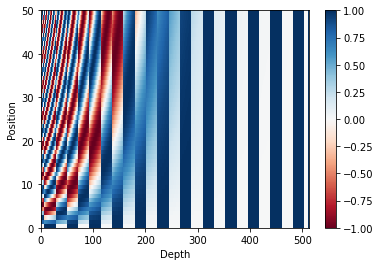

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

 논문에서 제시된 그림에서는 다음과 같이 포지셔널 인코딩을 표현해보면...
 
![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_9_l58gVWT.max-800x600.png?raw=true)

## 어텐션? 어텐션!

트랜스포머의 인코더와 디코더에서 사용하고 있는 개념인 어텐션에 대해서 알아보자!

### 어텐션이란?

어텐션 메커니즘을 그림으로 표현한다면 아래와 같이 표현할 수 있다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_10_AaCfqrY.png?raw=true)

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영해 주고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 한다.

### 트랜스포머에서 사용된 어텐션

트랜스포머는 총 세 가지의 어텐션을 사용하는데..

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_11_tFFhFjx.png?raw=true)

첫 번째 그림인 인코더 셀프 어텐션은 인코더에서 이루어지고,

두 번째 그림인 디코더 셀프 어텐션은 디코더에서 이루어지며,

세 번째 그림인 인코더-디코더 어텐션 또한 디코더에서 이루어집니다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_12_SIe2V15.png?raw=true)

위 그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 보여준다.

트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터' 이다.

단, 여기서 '단어 벡터' 란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터다.

그럼 위 세 가지 어텐션이 하는 일을 조금 더 자세히 알아보면...

- 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- 인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

### 셀프 어텐션(Self Attention)

셀프 어텐션이란 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말하는데 가령, 위에서 언급한 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 셀프 어텐션이 아니다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_13_hjMyZwL.png?raw=true)
위의 그림은 구글 AI 블로그 포스트에서 가져왔는데, 위의 예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.' 라는 의미가 됩니다. 그런데 여기서 그것(it) 에 해당하는 것은 과연 길(street) 일까요? 동물(animal) 일까요?

우리는 동물이라는 것을 쉽게 알 수 있지만, 기계는 그렇지 않다. 하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하여 그것(it) 이 동물(animal) 과 연관되었을 확률이 높다는 것을 찾아낸다. 그러면 유사도는 어떻게 구할까?

## 스케일드 닷 프로덕트 어텐션


트랜스포머에서는 어텐션 값을 구하는 방법으로 아래와 같은 수식을 사용했다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_14_pUfIgKn.png?raw=true)

Q,K,V는 각각 쿼리(Query), 키(Key), 값(Value)를 나타냅니다.

앞서 언급했던 어텐션 함수의 정의와 결괏값을 다시 상기해보면..

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해 준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 어텐션 값(Attention Value) 라고 한다.

위 정의와 아래 내용 세 가지만 기억하면 수식을 그림으로 정리할 수 있다.

Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
벡터의 내적(dot product) 은 벡터의 유사도를 의미한다.
특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.
우선 Q와 K의 전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같습니다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_15_pUfIgKn.png?raw=true)
문장 행렬 Q와 문장 행렬 K를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있다.

위 초록색 행렬이 의미하는 값은 무엇일까요? 예를 들어 'am' 행과 'student' 열의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값을 의미하며, 결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것이다

이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용한다. 여기까지가 Q와 K의 유사도를 구하는 과정이라고 볼 수 있으며, 여기에 문장 행렬 V와 곱하면 어텐션 값(Attention Value) 를 얻는다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_16_neA52rZ.png?raw=true)
결국 이를 모두 하나의 그림으로 표현하면 위와 같다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_14_pUfIgKn.png?raw=true)

이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention) 이라고 한다. 유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙는다.

만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 닷 프로덕트 어텐션(dot product attention) 이라고 부른다.

### 구현하기

스케일드 닷 프로덕트 어텐션 함수를 구현해면..

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


## 머리가 여러 개인 어텐션

### 병렬로 어텐션 수행하기

트랜스포머에서 num_heads라는 변수는 기계가 몇 개의 똑똑한 머리를 사용할지, 다시 말해 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터이다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_18_nnOTx9p.png?raw=true)

앞서 포지셔널 인코딩에서 d_model은 임베딩 벡터의 차원이라고 언급한 바 있습니다. 결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, d_model을 열의 크기로 가진다.

트랜스포머는 이렇게 입력된 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 num_heads의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate한다.

위의 그림은 num_heads가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 d_model이 된다.


### 멀티-헤드 어텐션

이렇게 병렬로 어텐션을 수행하면 얻을 수 있는 효과는 무엇일까?

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_19_FwmaA3q.png?raw=true)

위 그림은 num_heads의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여준다. 다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있는데... 예를 들어 위 그림에서라면 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻이다.

이와 같이 어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 부르다.

### 구현하기

멀티 헤드 어텐션을 구현하면 다음과 같습니다.

내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출합니다.

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


## 마스킹

마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.

### 패딩 마스킹(Padding Masking)
첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법이다.

자연어 처리에서 패딩(Padding)이란 어떤 개념일까?

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/1365906-20200410103623697-871078599.max-800x600.png?raw=true)
패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법이다.

위 그림은 케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 그림이다.

그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있으며, 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크한.

다음은 패딩 마스킹을 구현한 함수다.

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴한다.

두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 확인해 보면..

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다.

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다르다.

RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있고, 이 특징 때문에 추가적인 마스킹(Masking) 을 필요하다.

### RNN
RNN으로 다음 단어를 예측해가면서 문장을 생성해내는 과정을 보면..

다시 말해 RNN으로 디코더를 구현했을 경우

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_20_NAntZnv.max-800x600.png?raw=true)

RNN은 구조상으로 다음 단어를 만들어 갈 때, 자신보다 앞에 있는 단어들만 참고해서 다음 단어를 예측한다. 위의 그림을 참고로 각 단계에서 다음 단어 예측 과정을 서술하면 다음과 같다.

### 첫 번째 step

현재까지의 입력 : what → 출력 : is

### 두 번째 step

현재까지의 입력 : what is → 출력 : the

### 세 번째 step

현재까지의 입력 : what is the → 출력 problem

### 트랜스포머

트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있지만 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법이다.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/max-800x600.png?raw=true)

위의 그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있다. 빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있다. 행을 Query, 열을 Key로 표현된 행렬임을 감안하고 천천히 행렬을 살펴보면...

예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 <s>, <나는>, <행복을>, <찾고>까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있습니다. 즉, 유사도를 구할 수 없도록 해놓았다. 저 빨간색 부분을 마스킹 함수로 구현하면 다음과 같다.

In [8]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있는데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 한다. 그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있다.

숫자 0이 포함되었을 경우에도 테스트해 보면....

In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더


### 인코더 층 만들기

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_21_Y7Cy8sm.max-800x600.png?raw=true)

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어지며, 바로 셀프 어텐션과 피드 포워드 신경망이다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어진다.

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같다. 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있다.

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_22_teJgoCi.max-800x600.png?raw=true)

### 인코더 층을 쌓아 인코더 만들기

이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었는데, 위 그림에서는 Normalize라고 표시된 부분에 해당된다.

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓는다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정이다.

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## 디코더

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡한데 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다르다.

### 디코더 층

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_23_vBHZ3i0.max-800x600.png?raw=true)

첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망이다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/Untitled_24_Kj9egLY.max-800x600.png?raw=true)
인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다.

디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같다.

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 디코더 층을 쌓아 디코더 만들기

이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓는다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정이다.

In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


## 챗봇의 병렬 데이터 받아오기

여기서는 Cornell Movie-Dialogs Corpus라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용하는데 대화의 쌍이라고 하는 것은 기본적으로 먼저 말하는 사람의 대화 문장이 있고, 그에 응답하는 대화 문장의 쌍으로 이루어진다.

데이터를 받아오는 이번 스텝에서 목표로 하는 것은 다음과 같다.

- 정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.
- 문장에서 단어와 구두점 사이에 공백을 추가한다.
- 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

In [15]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')
print("슝=3")

슝=3


여기서 우리가 사용할 데이터는 실습 시간을 고려하여 전체 데이터 중 일부로, 우선, 데이터 중에서 5만 개만 가져오도록 하고 질문과 답변의 쌍의 형태로 데이터셋을 가공한다.

In [16]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


이를 위한 전처리 함수는 다음과 같다.

이번 전처리는 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 한다.

In [17]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [18]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs
print("슝=3")

슝=3


In [19]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 한다.

둘 다 5만 개의 샘플이 저장되었다.

임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 보면...

In [20]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


## 병렬 데이터 전처리하기

질문과 답변의 셋을 각각 questions와 answers에 저장하였으므로, 본격적으로 전처리를 진행해보겠습니다. 이번 스텝에서 진행할 전체적인 과정을 요약하면 다음과 같다.

- TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
- 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
- MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

### 1. 단어장(Vocabulary) 만들기

우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들고, 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [21]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


❗(주의) Tensorflow 2.2.0 이하의 버전에서는 아래 주석의 코드를 대신 실행할것....

In [22]:
import tensorflow_datasets as tfds
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


이때 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 준다. 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여한다

In [23]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [24]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]


각각 8,331과 8,332라는 점에서 현재 단어장의 크기가 8,331(0번부터 8,330번)이라는 의미이다.

두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 한다.

In [25]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 보면...

In [26]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행한다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 한다.

In [27]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [28]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [29]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


### 3. 교사 강요(Teacher Forcing) 사용하기

tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 한다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 한다. 

이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR) 이라고 한다. 

RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델입니다.

트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용.

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성하는데 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## 모델 정의 및 학습하기



In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 1. 모델 생성

num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값이다.

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용한다.

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2. 손실 함수(Loss function)

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### 3. 커스텀 된 학습률(Learning rate)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용하며, 논문에 나온 공식은 다음과 같다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/15/etc/max-800x600-1.png?raw=true)

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 보면 위에 언급한 수식은 step_num<sup>-0.5</sup> 에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있다. 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다.

Text(0.5, 0, 'Train Step')

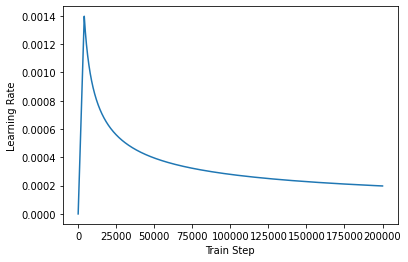

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4. 모델 컴파일

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


### 5. 훈련하기

총 20 에포크를 학습.

In [37]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
689/689 [==============================] - 85s 113ms/step - loss: 2.4847 - accuracy: 0.0252
Epoch 2/20
689/689 [==============================] - 82s 119ms/step - loss: 1.5478 - accuracy: 0.0766
Epoch 3/20
689/689 [==============================] - 87s 126ms/step - loss: 1.4085 - accuracy: 0.0852
Epoch 4/20
689/689 [==============================] - 93s 135ms/step - loss: 1.3461 - accuracy: 0.0904
Epoch 5/20
689/689 [==============================] - 98s 142ms/step - loss: 1.2904 - accuracy: 0.0946
Epoch 6/20
689/689 [==============================] - 96s 139ms/step - loss: 1.2448 - accuracy: 0.0991
Epoch 7/20
689/689 [==============================] - 99s 144ms/step - loss: 1.1793 - accuracy: 0.1026
Epoch 8/20
689/689 [==============================] - 97s 141ms/step - loss: 1.1178 - accuracy: 0.1086
Epoch 9/20
689/689 [==============================] - 99s 143ms/step - loss: 1.0582 - accuracy: 0.1148
Epoch 10/20
689/689 [==============================] - 100s 146ms/step - 

## 챗봇 테스트하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

- 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
- 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
- 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
- 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
- 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
- END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만든다.

In [38]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만든다.

In [39]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


임의의 문장으로부터 챗봇의 대답을 얻어보자.

In [40]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m a catholic .


'i m a catholic .'

In [41]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m sorry , i don t know what to say that .


'i m sorry , i don t know what to say that .'

## 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜보자.

### Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용.

이 데이터는 아래의 링크에서 다운로드할 수 있다.

songys/Chatbot_data

$ mkdir -p ~/aiffel/EXPLORATION/15/transformer_chatbot/data/

$ ln -s ~/data/* ~/aiffel/EXPLORATION/15/transformer_chatbot/data/

라이브러리 불러오기

In [42]:
import os
import re
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

데이터 로드

In [43]:
dataset_file_path = os.getenv('HOME') + '/aiffel/EXPLORATION/15/transformer_chatbot/data/ChatbotData.csv'
dataset_file_path

'/aiffel/aiffel/EXPLORATION/15/transformer_chatbot/data/ChatbotData.csv'

### Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있다.

In [44]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 영어 포함 시 소문자 변환, 양쪽 공백 제거
    sentence = sentence.lower().strip()
    
    # 단어와 구두점 사이 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글, 알파벳, .,?!을 제외한 문자 공백으로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [45]:
def load_conversations():
    with open(dataset_file_path, errors='ignore') as file:
        lines = file.readlines()
        
    inputs, outputs = [], []
    with open(dataset_file_path) as file:
        lines = csv.reader(file)
        next(lines)
        for line in lines:
            inputs.append(preprocess_sentence(line[0]))
            outputs.append(preprocess_sentence(line[1]))
    return inputs, outputs

In [46]:
questions, answers = load_conversations()

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print()
print('전처리 후의 11번째 질문 샘플: {}'.format(questions[11]))
print('전처리 후의 11번째 답변 샘플: {}'.format(answers[11]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823

전처리 후의 11번째 질문 샘플: 가끔 궁금해
전처리 후의 11번째 답변 샘플: 그 사람도 그럴 거예요 .


### Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용.

토크나이징
단어장(Vocabulary) 만들기 - SubwordTextEncoder 이용

In [47]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [48]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


In [49]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


정수 인코딩 & 패딩 & start, end token 추가
- tokenizer.encode() : 단어 > 정수
- tokenizer.decode() : 정수 > 단어

In [50]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9391017508246637
answers 최대 길이 : 24
answers 평균 길이 : 4.716146494121627


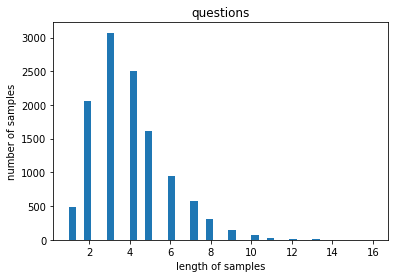

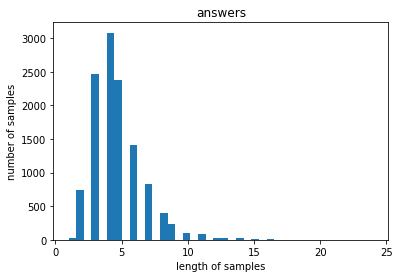

In [51]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
# 최대 허용 길이 지정
MAX_LENGTH = 10

# 정수인코딩, 최대길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작, 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이 10으로 모든 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs

In [53]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 9128
필터링 후의 답변 샘플 개수: 9128


교사 강요(Teacher Forcing) 사용하기

In [54]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [55]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 10), dec_inputs: (None, 9)}, {outputs: (None, 9)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

### Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현.

In [56]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

Scaled Dot Product Attention

내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구함

In [57]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)  # # tf.matmul : 두 텐서를 행렬곱한 결과 텐서를 리턴

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output


Multi Head Attention
- 내부적으로는 스케일드 닷 프로덕트 어테션 함수를 호출

In [58]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

Masking

특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

Padding Masking

문자의 길이를 맞추기 위해서 패딩을 넣어 처리해준 부분은 실제 의미가 있는 단어가 아니므로 패딩부분을 마스킹하여 가려준다.

In [59]:
# 0인 위치에서 숫자 1이 나오고, 숫자0이 아닌 위치는 숫자0이 나오게 하는 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

Look-ahead Masking 다음 단어 가리기

RNN은 각 step마다 순서대로 들어가는 반면, 트랜스포머는 문장행렬을 만들어 한 번에 행렬형태로 입력으로 들어가기 때문에 마스킹을 한다.

In [60]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

인코더

- 하나의 인코더 층은 2개의 서브 층으로 나뉜다.
  - 셀프어텐션(멀티 헤드 어텐션)
  - 피드 포워드 신경망

In [61]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [62]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더
- 셀프 어텐션
- 인코더-디코더 어텐션 : query가 디코더의 벡터, key-value가 인코더의 벡터
- 피드 포워드 신경망

In [63]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )


In [64]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )


모델 정의 및 훈련

In [65]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='enc_padding_mask'
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='dec_padding_mask'
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

모델생성

In [66]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3136768     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

손실함수

레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [67]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

커스텀된 학습률 learning rate

In [68]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

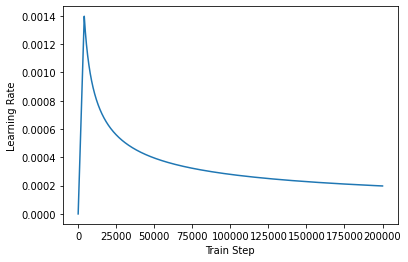

In [69]:
# 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

모델 컴파일

In [70]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


훈련

In [71]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
143/143 [==============================] - 14s 51ms/step - loss: 5.8032 - accuracy: 0.0584
Epoch 2/50
143/143 [==============================] - 7s 50ms/step - loss: 4.9646 - accuracy: 0.2031
Epoch 3/50
143/143 [==============================] - 7s 50ms/step - loss: 4.0789 - accuracy: 0.2149
Epoch 4/50
143/143 [==============================] - 7s 50ms/step - loss: 3.5475 - accuracy: 0.2172
Epoch 5/50
143/143 [==============================] - 7s 50ms/step - loss: 3.3414 - accuracy: 0.2280
Epoch 6/50
143/143 [==============================] - 7s 50ms/step - loss: 3.1020 - accuracy: 0.2403
Epoch 7/50
143/143 [==============================] - 7s 50ms/step - loss: 2.9269 - accuracy: 0.2538
Epoch 8/50
143/143 [==============================] - 7s 50ms/step - loss: 2.7049 - accuracy: 0.2767
Epoch 9/50
143/143 [==============================] - 7s 50ms/step - loss: 2.4685 - accuracy: 0.3045
Epoch 10/50
143/143 [==============================] - 7s 49ms/step - loss: 2.2083 - accur

### Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듬

In [72]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331  86  30  5  1059  7  8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [73]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 함수
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


In [74]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 좀 더 일찍 잠자리에 들어보세요 .


'좀 더 일찍 잠자리에 들어보세요 .'

In [75]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 제가 곁에 있을게요 .


'제가 곁에 있을게요 .'

In [76]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 서로를 알게 되었겠네요 .


'서로를 알게 되었겠네요 .'

In [77]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 어이 없는 일이 있었나봐요 .


'어이 없는 일이 있었나봐요 .'

D_MODEL = 256 -> 512

In [78]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    7321088     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [79]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [80]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
143/143 [==============================] - 20s 91ms/step - loss: 5.6662 - accuracy: 0.0584
Epoch 2/50
143/143 [==============================] - 13s 94ms/step - loss: 4.2517 - accuracy: 0.2131
Epoch 3/50
143/143 [==============================] - 13s 92ms/step - loss: 3.6428 - accuracy: 0.2170
Epoch 4/50
143/143 [==============================] - 14s 97ms/step - loss: 3.3865 - accuracy: 0.2278
Epoch 5/50
143/143 [==============================] - 13s 94ms/step - loss: 3.1755 - accuracy: 0.2385
Epoch 6/50
143/143 [==============================] - 14s 95ms/step - loss: 2.9193 - accuracy: 0.2540
Epoch 7/50
143/143 [==============================] - 14s 95ms/step - loss: 2.6633 - accuracy: 0.2816
Epoch 8/50
143/143 [==============================] - 14s 98ms/step - loss: 2.3786 - accuracy: 0.3198
Epoch 9/50
143/143 [==============================] - 14s 100ms/step - loss: 2.0750 - accuracy: 0.3580
Epoch 10/50
143/143 [==============================] - 14s 97ms/step - loss: 1.72

In [81]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 충전하는 시간 그 자체로 소중합니다 .


'충전하는 시간 그 자체로 소중합니다 .'

In [82]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 바람이라도 쐬고 오는 건 어떨까요 .


'바람이라도 쐬고 오는 건 어떨까요 .'

In [83]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 그럼요 . 연락해보세요 .


'그럼요 . 연락해보세요 .'

In [84]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 맛있는 드세요 .


'맛있는 드세요 .'

NUM_LAYERS = 2 -> 5

In [85]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 5 # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12055040    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [86]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [87]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
143/143 [==============================] - 39s 164ms/step - loss: 5.5960 - accuracy: 0.0620
Epoch 2/50
143/143 [==============================] - 24s 167ms/step - loss: 4.3026 - accuracy: 0.2000
Epoch 3/50
143/143 [==============================] - 24s 171ms/step - loss: 3.6645 - accuracy: 0.2165
Epoch 4/50
143/143 [==============================] - 25s 172ms/step - loss: 3.4603 - accuracy: 0.2210
Epoch 5/50
143/143 [==============================] - 25s 176ms/step - loss: 3.2953 - accuracy: 0.2298
Epoch 6/50
143/143 [==============================] - 25s 175ms/step - loss: 3.1325 - accuracy: 0.2401
Epoch 7/50
143/143 [==============================] - 25s 175ms/step - loss: 2.9493 - accuracy: 0.2542
Epoch 8/50
143/143 [==============================] - 26s 180ms/step - loss: 2.7234 - accuracy: 0.2725
Epoch 9/50
143/143 [==============================] - 26s 179ms/step - loss: 2.4601 - accuracy: 0.3005
Epoch 10/50
143/143 [==============================] - 26s 178ms/step - l

In [88]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 푹 쉬세요 .


'푹 쉬세요 .'

In [89]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 약 먹고 쉬어야 해요 .


'약 먹고 쉬어야 해요 .'

In [90]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 오래 볼 수 있어 좋은 가봐요 .


'오래 볼 수 있어 좋은 가봐요 .'

In [91]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 색다른걸 드셔보세요 .


'색다른걸 드셔보세요 .'

EPOCHS = 50 ->200

In [92]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 5 # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12055040    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [93]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [94]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
143/143 [==============================] - 39s 161ms/step - loss: 5.6611 - accuracy: 0.0559
Epoch 2/200
143/143 [==============================] - 24s 165ms/step - loss: 4.3517 - accuracy: 0.1761
Epoch 3/200
143/143 [==============================] - 24s 171ms/step - loss: 3.6460 - accuracy: 0.2157
Epoch 4/200
143/143 [==============================] - 25s 175ms/step - loss: 3.4396 - accuracy: 0.2226
Epoch 5/200
143/143 [==============================] - 26s 180ms/step - loss: 3.2843 - accuracy: 0.2292
Epoch 6/200
143/143 [==============================] - 26s 181ms/step - loss: 3.1604 - accuracy: 0.2400
Epoch 7/200
143/143 [==============================] - 26s 181ms/step - loss: 2.9572 - accuracy: 0.2535
Epoch 8/200
143/143 [==============================] - 26s 184ms/step - loss: 2.7158 - accuracy: 0.2721
Epoch 9/200
143/143 [==============================] - 26s 179ms/step - loss: 2.4751 - accuracy: 0.2995
Epoch 10/200
143/143 [==============================] - 26s 185m

143/143 [==============================] - 27s 187ms/step - loss: 0.0222 - accuracy: 0.6631
Epoch 80/200
143/143 [==============================] - 26s 185ms/step - loss: 0.0195 - accuracy: 0.6616
Epoch 81/200
143/143 [==============================] - 27s 186ms/step - loss: 0.0193 - accuracy: 0.6631
Epoch 82/200
143/143 [==============================] - 27s 186ms/step - loss: 0.0191 - accuracy: 0.6603
Epoch 83/200
143/143 [==============================] - 26s 185ms/step - loss: 0.0196 - accuracy: 0.6649
Epoch 84/200
143/143 [==============================] - 27s 186ms/step - loss: 0.0155 - accuracy: 0.6649
Epoch 85/200
143/143 [==============================] - 27s 188ms/step - loss: 0.0204 - accuracy: 0.6605
Epoch 86/200
143/143 [==============================] - 27s 187ms/step - loss: 0.0209 - accuracy: 0.6587
Epoch 87/200
143/143 [==============================] - 27s 186ms/step - loss: 0.0165 - accuracy: 0.6621
Epoch 88/200
143/143 [==============================] - 26s 183ms/st

143/143 [==============================] - 27s 189ms/step - loss: 0.0070 - accuracy: 0.6650
Epoch 161/200
143/143 [==============================] - 27s 191ms/step - loss: 0.0081 - accuracy: 0.6647
Epoch 162/200
143/143 [==============================] - 27s 186ms/step - loss: 0.0085 - accuracy: 0.6639
Epoch 163/200
143/143 [==============================] - 27s 188ms/step - loss: 0.0078 - accuracy: 0.6606
Epoch 164/200
143/143 [==============================] - 27s 187ms/step - loss: 0.0083 - accuracy: 0.6633
Epoch 165/200
143/143 [==============================] - 27s 188ms/step - loss: 0.0105 - accuracy: 0.6612
Epoch 166/200
143/143 [==============================] - 27s 187ms/step - loss: 0.0058 - accuracy: 0.6619
Epoch 167/200
143/143 [==============================] - 27s 187ms/step - loss: 0.0093 - accuracy: 0.6632
Epoch 168/200
143/143 [==============================] - 26s 185ms/step - loss: 0.0086 - accuracy: 0.6638
Epoch 169/200
143/143 [==============================] - 27s

In [95]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 눈 체조를 해보세요 .


'눈 체조를 해보세요 .'

In [96]:
sentence_generation('졸려 죽겠어')

입력 : 졸려 죽겠어
출력 : 친구를 사귀어 보세요 .


'친구를 사귀어 보세요 .'

In [97]:
sentence_generation('주말이 언제 올까?')

입력 : 주말이 언제 올까?
출력 : 사랑의 보통은 없죠 .


'사랑의 보통은 없죠 .'

In [98]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 누구랑 가느냐가 중요하겠죠 .


'누구랑 가느냐가 중요하겠죠 .'

## 회고

처음 프로젝트 코드를 진행했을때 출력값이 마침표 하나만 나와서 당황했다. 그래서 불러온 쳇봇 데이터가 잘못되었나 생각되어 

https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv 의 데이터를 다시 불러와보니 용량차이도 있어서 데이터를 잘못 불러온것을 확신 하였다. 그러나 결과가 비슷하였고 다시 확인해보니 전처리 과정을 빼먹고 진행하고 있었음을 알수있엇다. 

데이터두 바꾸고 전처리 과정두 진행하니 정상적으로 토크나이저를 통해서 단어장이 생성됨을 확인할 수 있었다.

D_MODEL 을 256 ->512 로 변경해 보았으며, NUM_LAYERS 를 2-> 5로 변경시도 해보고 EPOCHS 도 50 -> 200 으로 올려 보았다.

질문에 따라서 처음부터 매끄러운 답변을 확인할 수 있엇던 내용도 있었으며.. 여러 시도를 해도 동문서답 같은 답변을 주는 것도 확인할 수 있었다.

그런데 생각보다 자연스러운 답을 받을수 있어서 처음 siri를 통해서 "인생이란?" 이라고 질문을 던졌을때 받아본 답변에 놀랐던 과거가 생각나면서 챗봇이 진화하면 충분히 사람과 원활한 대화를 나누면서도 상대방이 챗봇임을 눈치채지 못하는 경지에 이를수 있겟다는 생각이 들었다.